In [1]:
! pip install gdown --quiet

In [2]:
import warnings
warnings.filterwarnings("ignore")
# Library imports
from glob import glob
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2 as cv
import random
from os import listdir
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import gdown

2024-03-28 02:12:38.703328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 02:12:38.703432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 02:12:38.831878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
url = 'https://drive.google.com/uc?id=1nbMBiC3iT0CYkhRmQKiqaVYknD-EO2aS'
output = 'hasil_final.zip'
gdown.download(url, output)

!unzip -q hasil_final.zip -d /kaggle/working
! rm /kaggle/working/hasil_final.zip

Downloading...
From (original): https://drive.google.com/uc?id=1nbMBiC3iT0CYkhRmQKiqaVYknD-EO2aS
From (redirected): https://drive.google.com/uc?id=1nbMBiC3iT0CYkhRmQKiqaVYknD-EO2aS&confirm=t&uuid=80ac3eec-e017-472c-9b73-7ce5d636721a
To: /kaggle/working/hasil_final.zip
100%|██████████| 1.84G/1.84G [00:15<00:00, 119MB/s] 


In [4]:
UKURAN_GAMBAR = 50

def tambah_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

def crop_gambar(img, frac=.7):
    left = img.size[0]*((1-frac)/2)
    upper = img.size[1]*((1-frac)/2)
    right = img.size[0]-((1-frac)/2)*img.size[0]
    bottom = img.size[1]-((1-frac)/2)*img.size[1]
    cropped_img = img.crop((left, upper, right, bottom))
    return cropped_img

def show_image(img, title=None):
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    
def buat_kotak(img):
    h, w = img.shape[:2]
    
    if h > w:
        new_w = int((h - w) / 2)
        return cv.copyMakeBorder(img, 0, 0, new_w, new_w, cv.BORDER_CONSTANT, None, value=0)
    else:
        new_h = int((w - h) / 2)
        return cv.copyMakeBorder(img, new_h, new_h, 0, 0, cv.BORDER_CONSTANT, None, value=0)
    
def tambah_margin(img, persen = 0):
    h, w = img.shape[:2]
    new_h = int(h * persen / 2)
    new_w = int(w * persen / 2)
    return cv.copyMakeBorder(img, new_h, new_h, new_w, new_w, cv.BORDER_CONSTANT, None, value=0)



In [5]:
def konverter_hasil(induk, anak):
    if anak[0].lower() == 'a':
        hasil = induk + anak[1:]
    elif str(anak) == '0':
        hasil = induk[0]
    else:
        hasil = induk[0] + anak
    return hasil.lower()

In [6]:
def parse_dataset(dataset_path, ext='jpg'):
    files = glob(os.path.join(dataset_path, '*/*', f'*.{ext}'))
    
    records = []
    for file in files:
        file_dir = os.path.dirname(file).split('/')
        induk_aksara = file_dir[-2]
        anak_aksara = file_dir[-1]
        records.append((induk_aksara, anak_aksara))
    
    df = pd.DataFrame(records)
    df.insert(loc = 0, column = 'file', value = files)
    df.columns = ['file', 'induk_aksara', 'anak_aksara']
    df = df.dropna()
    
    return df
df = parse_dataset('/kaggle/working/content/hasil_final')
df.head()

,file,induk_aksara,anak_aksara
0,/kaggle/working/content/hasil_final/Ya/0/644.jpg,Ya,0
1,/kaggle/working/content/hasil_final/Ya/0/3113.jpg,Ya,0
2,/kaggle/working/content/hasil_final/Ya/0/2688.jpg,Ya,0
3,/kaggle/working/content/hasil_final/Ya/0/2828.jpg,Ya,0
4,/kaggle/working/content/hasil_final/Ya/0/3537.jpg,Ya,0


In [7]:
class DataGenerator():
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self, persen_latih):
        p = np.random.permutation(len(self.df))
        jumlah_data_latih = int(len(self.df) * persen_latih)
        id_latih, id_uji = p[:jumlah_data_latih], p[jumlah_data_latih:]
        jumlah_data_latih = int(jumlah_data_latih * persen_latih)
        id_latih, id_validasi = id_latih[:jumlah_data_latih], id_latih[jumlah_data_latih:]
        
        encoder_induk = LabelEncoder()
        self.df['id_induk'] = encoder_induk.fit_transform(self.df['induk_aksara'])
        encoder_anak = LabelEncoder()
        self.df['id_anak'] = encoder_anak.fit_transform(self.df['anak_aksara'])
        
        return id_latih, id_uji, id_validasi, encoder_induk, encoder_anak
    
    def preprocess_image(self, img_path, img_size):
        image = cv.imread(img_path)
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, thresh = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV)
        resized = cv.resize(thresh, img_size)
        img = np.array(resized) / 255.0
        
        return img
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        # arrays to store our batched data
        images, induk, anak = [], [], []
        while True:
            for idx in image_idx:
                aksara = self.df.iloc[idx]
                
                file = aksara['file']
                id_induk = aksara['id_induk']
                id_anak = aksara['id_anak']
                
                img = self.preprocess_image(file, (UKURAN_GAMBAR, UKURAN_GAMBAR))
                
                images.append(img)
                induk.append(id_induk)
                anak.append(id_anak)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), (np.array(induk), np.array(anak))
                    images, induk, anak = [], [], []
                    
            if not is_training:
                break
                
data_generator = DataGenerator(df)
id_latih, id_uji, id_validasi, encoder_induk, encoder_anak = data_generator.generate_split_indexes(0.75)

In [ ]:
# checkpoint2
class KonversiAksaraModel():
    def make_default_hidden_layers(self, inputs):
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.3)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.3)(x)
        return x
    def build_induk_branch(self, inputs, jumlah_induk):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(750)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.45)(x)
        x = Dense(500)(x)
        x = Activation("relu")(x)
        x = Dense(jumlah_induk)(x)
        x = Activation("softmax", name="induk_output")(x)
        return x
    def build_anak_branch(self, inputs, jumlah_anak):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(750)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.45)(x)
        x = Dense(500)(x)
        x = Activation("relu")(x)
        x = Dense(jumlah_anak)(x)
        x = Activation("softmax", name="anak_output")(x)
        return x
    def assemble_full_model(self, width, height, jumlah_induk, jumlah_anak):
        input_shape = (height, width, 1)
        inputs = Input(shape=input_shape)
        induk_branch = self.build_induk_branch(inputs, jumlah_induk)
        anak_branch = self.build_anak_branch(inputs, jumlah_anak)
        model = Model(inputs=inputs,
                      outputs = [induk_branch, anak_branch],
                      name="konversi_aksara")
        return model

jumlah_induk = len(df['induk_aksara'].unique())
jumlah_anak = len(df['anak_aksara'].unique())
model = KonversiAksaraModel().assemble_full_model(UKURAN_GAMBAR, UKURAN_GAMBAR, jumlah_induk, jumlah_anak)
checkpoint2

In [8]:
class KonversiAksaraModel():
    def make_default_hidden_layers(self, inputs):
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.35)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.3)(x)
        return x
    def build_induk_branch(self, inputs, jumlah_induk):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(500)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.45)(x)
        x = Dense(500)(x)
        x = Activation("relu")(x)
        x = Dense(jumlah_induk)(x)
        x = Activation("softmax", name="induk_output")(x)
        return x
    def build_anak_branch(self, inputs, jumlah_anak):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(500)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.45)(x)
        x = Dense(500)(x)
        x = Activation("relu")(x)
        x = Dense(jumlah_anak)(x)
        x = Activation("softmax", name="anak_output")(x)
        return x
    def assemble_full_model(self, width, height, jumlah_induk, jumlah_anak):
        input_shape = (height, width, 1)
        inputs = Input(shape=input_shape)
        induk_branch = self.build_induk_branch(inputs, jumlah_induk)
        anak_branch = self.build_anak_branch(inputs, jumlah_anak)
        model = Model(inputs=inputs,
                      outputs = [induk_branch, anak_branch],
                      name="konversi_aksara")
        return model

jumlah_induk = len(df['induk_aksara'].unique())
jumlah_anak = len(df['anak_aksara'].unique())
model = KonversiAksaraModel().assemble_full_model(UKURAN_GAMBAR, UKURAN_GAMBAR, jumlah_induk, jumlah_anak)

In [12]:
init_lr = 1e-4
epochs = 10
opt = Adam(init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={
                  'induk_output': 'sparse_categorical_crossentropy', 
                  'anak_output': 'sparse_categorical_crossentropy'},
              metrics={
                  'induk_output': 'accuracy',
                  'anak_output': 'accuracy'})

In [13]:
batch_size = 256
valid_batch_size = 256
train_gen = data_generator.generate_images(id_latih, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(id_validasi, is_training=True, batch_size=valid_batch_size)
callbacks = [
    ModelCheckpoint(filepath='/kaggle/working/checkpoint/cp.weights.h5',
                    save_weights_only=True, save_best_only=True,
                    monitor='loss', mode='auto', verbose=1)
]
history = model.fit(train_gen,
                    steps_per_epoch=len(id_latih)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(id_validasi)//valid_batch_size)

Epoch 1/10


2024-03-28 03:11:44.980767: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.14571, expected 1.32555
2024-03-28 03:11:44.980835: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.04824, expected 2.22808
2024-03-28 03:11:44.980844: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.06489, expected 2.24473
2024-03-28 03:11:44.980852: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.39188, expected 1.57172
2024-03-28 03:11:44.980860: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.3689, expected 1.54874
2024-03-28 03:11:44.980867: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.57798, expected 1.75782
2024-03-28 03:11:44.980875: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.28869, expected 1.46853
2024-03-28 03:11:44.980882: E external/local_xla/xla/ser

   4/2204 ━━━━━━━━━━━━━━━━━━━━ 1:54 52ms/step - anak_output_accuracy: 0.9955 - induk_output_accuracy: 0.9994 - loss: 0.0150 

W0000 00:00:1711595512.104076      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711595512.106596      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - anak_output_accuracy: 0.9941 - induk_output_accuracy: 0.9979 - loss: 0.0253

W0000 00:00:1711595654.910119      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711595654.911739      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: loss improved from inf to 0.02610, saving model to /kaggle/working/checkpoint/cp.weights.h5
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 201s 84ms/step - anak_output_accuracy: 0.9941 - induk_output_accuracy: 0.9979 - loss: 0.0253 - val_anak_output_accuracy: 0.9974 - val_induk_output_accuracy: 0.9984 - val_loss: 0.0153
Epoch 2/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - anak_output_accuracy: 0.9946 - induk_output_accuracy: 0.9982 - loss: 0.0234
Epoch 2: loss improved from 0.02610 to 0.02317, saving model to /kaggle/working/checkpoint/cp.weights.h5
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 187s 85ms/step - anak_output_accuracy: 0.9946 - induk_output_accuracy: 0.9982 - loss: 0.0234 - val_anak_output_accuracy: 0.9976 - val_induk_output_accuracy: 0.9985 - val_loss: 0.0141
Epoch 3/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - anak_output_accuracy: 0.9947 - induk_output_accuracy: 0.9983 - loss: 0.0224
Epoch 3: loss improved from 0.02317 to 0.02191, saving model to /kaggle/working/checkpoint/cp.weigh

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - anak_output_accuracy: 0.9966 - induk_output_accuracy: 0.9989 - loss: 0.0144
Epoch 9: loss improved from 0.01523 to 0.01425, saving model to /kaggle/working/checkpoint/cp.weights.h5
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 193s 87ms/step - anak_output_accuracy: 0.9966 - induk_output_accuracy: 0.9989 - loss: 0.0144 - val_anak_output_accuracy: 0.9983 - val_induk_output_accuracy: 0.9992 - val_loss: 0.0094
Epoch 10/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - anak_output_accuracy: 0.9967 - induk_output_accuracy: 0.9989 - loss: 0.0138
Epoch 10: loss improved from 0.01425 to 0.01385, saving model to /kaggle/working/checkpoint/cp.weights.h5
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 165s 75ms/step - anak_output_accuracy: 0.9967 - induk_output_accuracy: 0.9989 - loss: 0.0138 - val_anak_output_accuracy: 0.9984 - val_induk_output_accuracy: 0.9994 - val_loss: 0.0089


In [14]:
import time
for i in range(60*15):
    time.sleep(1)

In [59]:
from sklearn.metrics import accuracy_score
pr = []
n = 1000
for ra in range(n):
    tp = X_test[ra].reshape(1, *X_test[ra].shape)
    predicted = np.argmax(cnn_model.predict(tp, verbose=0))
    pr.append(predicted)
    
pr = np.array(pr)
accuracy_score(y_test[:n], pr)

0.999

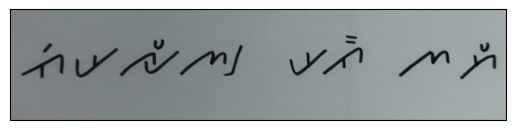

In [12]:
show_image(cv.imread('/kaggle/input/tes-mo/WhatsApp Image 2024-03-20 at 12.15.44 PM.jpeg'))

(95, 76)
(86, 103)
(75, 73)
(76, 92)
(72, 87)
(73, 68)
(74, 119)
(65, 69)
(66, 122)


'Heggo koma maimahhmah'

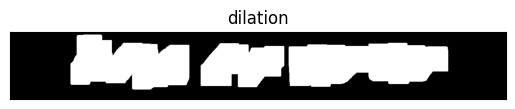

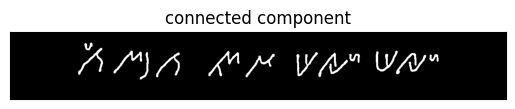

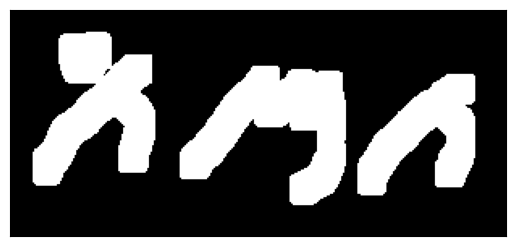

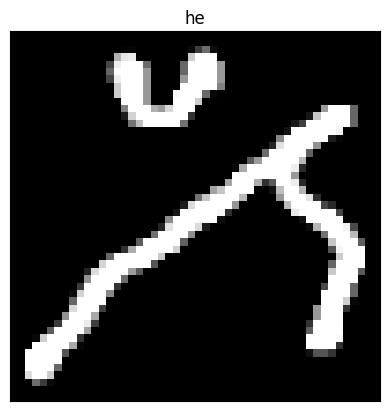

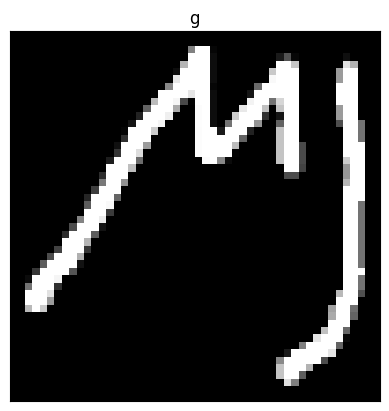

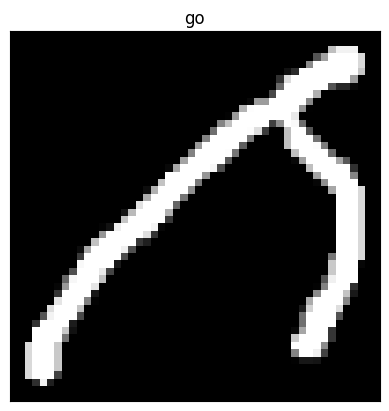

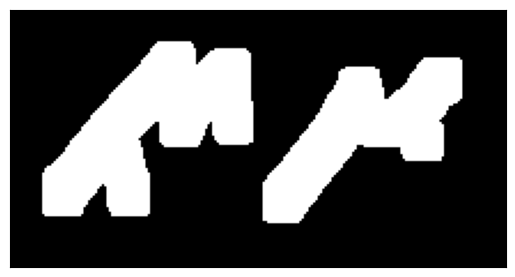

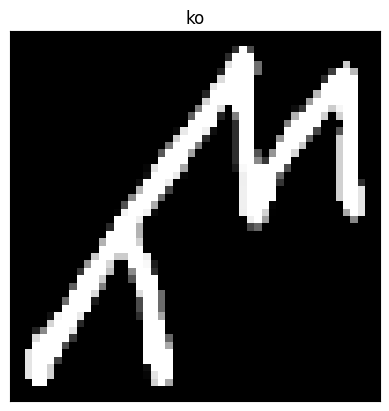

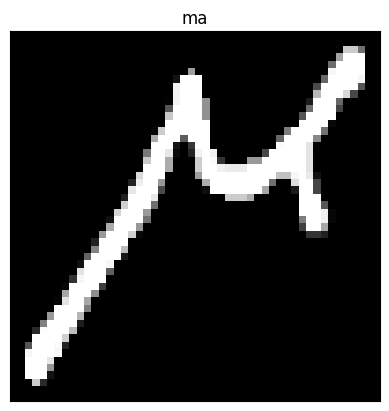

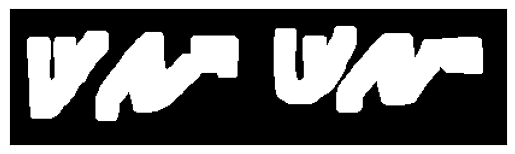

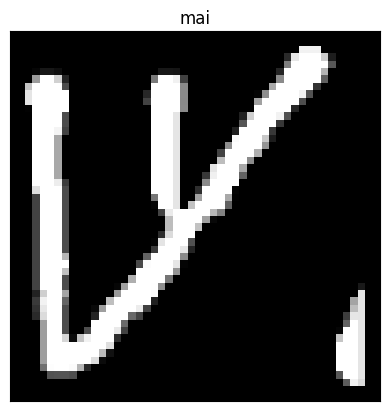

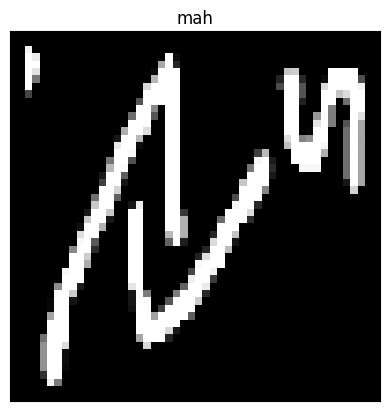

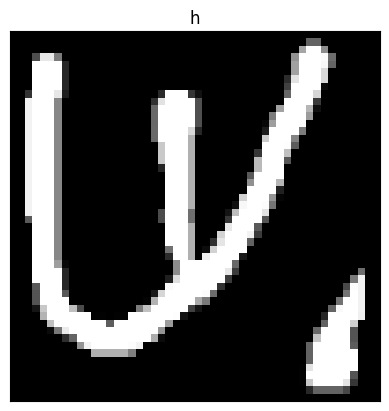

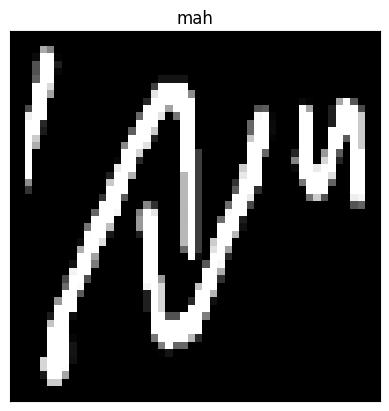

In [11]:
tes = cv.imread('/kaggle/input/tes-ygy3/WhatsApp Image 2024-03-19 at 8.43.28 PM.jpeg')
gray = cv.cvtColor(tes, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (9,9), 0)
_, thresh = cv.threshold(blur, 150, 255, cv.THRESH_BINARY_INV)
th2 = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV,11,2)

nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(th2, None, None, None, 8, cv.CV_32S)
sizes = stats[1:, -1] #get CC_STAT_AREA component
img2 = np.zeros((labels.shape), np.uint8)

for i in range(0, nlabels - 1):
    if sizes[i] >= 150:   #filter small dotted regions
        img2[labels == i + 1] = 255

kernel2 = cv.getStructuringElement(cv.MORPH_RECT, (10,10))
dilation = cv.dilate(img2, kernel2, iterations=5)

contours, _ = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[0])

list_kata = []
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    crop_img = img2[y:y + h, x:x + w]
    list_kata.append(crop_img)

# show_image(thresh, 'manual threshold')
# show_image(th2, 'adaptive threshold')
show_image(dilation, 'dilation')
# show_image(tes, 'gambar asli')
show_image(img2, 'connected component')

teks = []
for kata in list_kata:
    hasil_kata = ""
    kernel_aksara = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
    dilation_aksara = cv.dilate(kata, kernel_aksara, iterations=3)
    show_image(dilation_aksara)
    contours, _ = cv.findContours(dilation_aksara, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[0])
    for aksara in contours:
        x, y, w, h = cv.boundingRect(aksara)
        gambar_aksara = kata[y:y + h, x:x + w]
        kernel_aksara = cv.getStructuringElement(cv.MORPH_RECT, (5,7))
        dilation_aksara = cv.dilate(gambar_aksara, kernel_aksara, iterations=4)
        
        nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(dilation_aksara, None, None, None, 8, cv.CV_32S)
        sizes = stats[1:, -1]
        img2 = np.zeros((labels.shape), np.uint8)
        
        for i in range(0, nlabels - 1):
            if sizes[i] >= (sizes.max() // 2):
                img2[labels == i + 1] = 255
        print(labels.shape)
        
        contours, _ = cv.findContours(gambar_aksara, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        contour = contours[0]
        if len(contours) > 1:
            for ctr in contours[1:]:
                contour = np.vstack((contour, ctr))
            contour = cv.convexHull(contour)
        x, y, w, h = cv.boundingRect(contour)
        crop_img = gambar_aksara[y:y + h, x:x + w]
        
        margin = tambah_margin(crop_img, .1)
        resized = cv.resize(margin, (UKURAN_GAMBAR, UKURAN_GAMBAR))
        to_predict = resized.reshape(1, *resized.shape, 1) / 255.0
        predicted_induk = encoder_induk.inverse_transform([np.argmax(model.predict(to_predict, verbose=0)[0])])
        predicted_anak = encoder_anak.inverse_transform([np.argmax(model.predict(to_predict, verbose=0)[1])])
        haa = konverter_hasil(predicted_induk[0], predicted_anak[0])
        show_image(resized, haa)
        hasil_kata += haa
    teks.append(hasil_kata)
" ".join(teks).capitalize()

In [ ]:
show_image(tes)
for k in list_kata:
    show_image(k)

In [15]:
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 5500:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

NameError: name 'cv2' is not defined

(119, 132)
(98, 125)
(148, 133)
(146, 107)
(98, 113)
(94, 89)
(114, 103)
(123, 138)
(134, 99)
(141, 110)


'Maikanan sanhata bergiji'

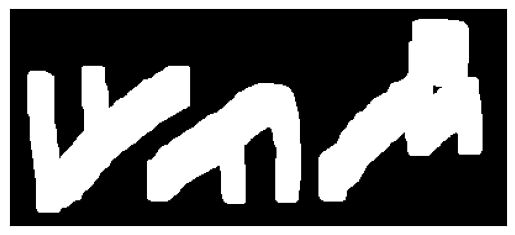

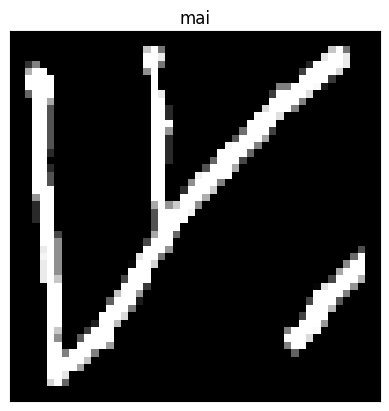

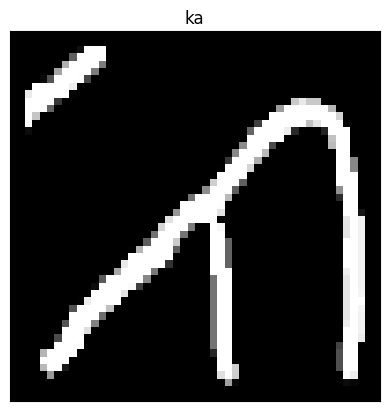

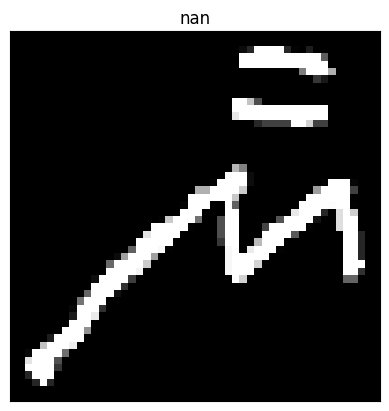

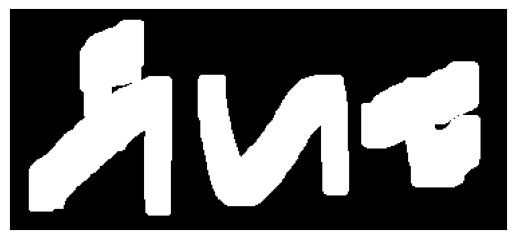

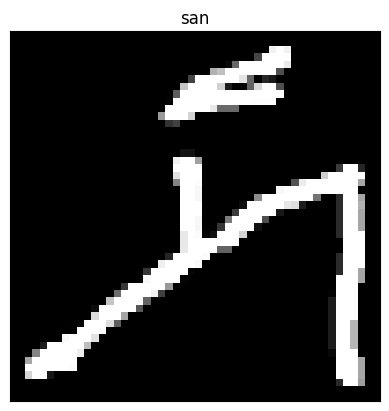

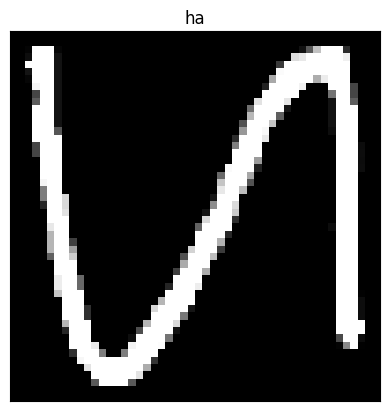

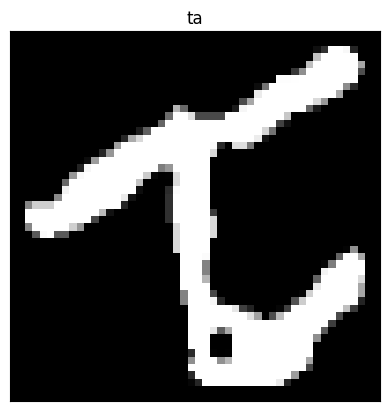

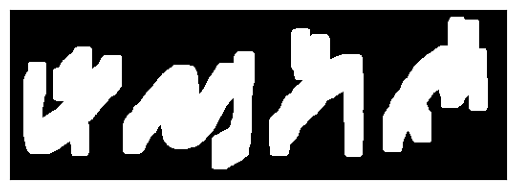

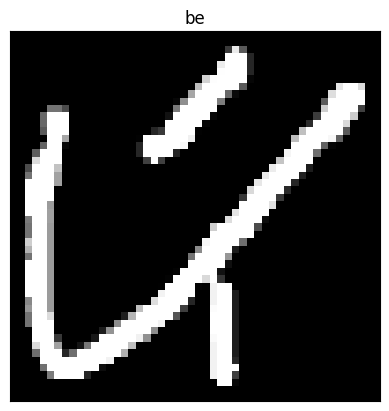

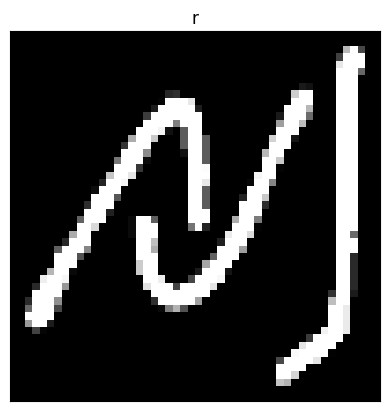

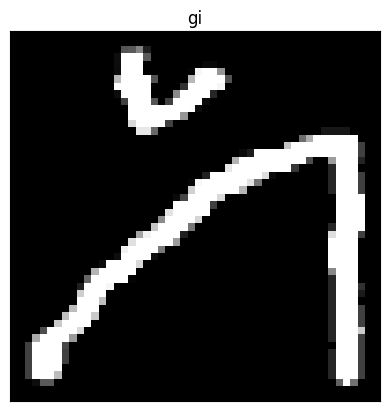

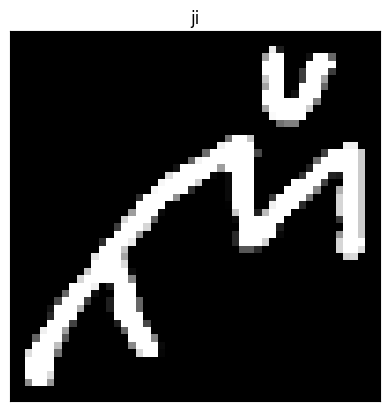

In [ ]:
# Saving model
# model.save("/content/flower_species.h5")
# Let's visualize the model training and loss history.
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()